In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import os
import sys
import time

In [3]:
sys.path.append("/workspace/main-pe/")

In [4]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [5]:
from data.datasets.mpii import MpiiSinglePerson
from data.utils.data_utils import TEST_MODE, TRAIN_MODE, VALID_MODE
from data.loader import BatchLoader

In [6]:
from model import config
from model import callbacks
from model.utils import pose_format

In [7]:
from experiments.common import exp_init

In [8]:
# for custom objects
from model.activations import channel_softmax_2d
from model.losses import reconstruction_loss, pose_loss

# datasets

In [9]:
conf = {
    'pose_blocks': 2,
    'batch_size': 16,
    'dim': 2,
    'n_joints': 16,
    'dataset_name': 'mpii',
    'n_epochs': 2
}

In [10]:
mpii_path = '/workspace/datasets/mpii'
mpii = MpiiSinglePerson(mpii_path, dataconf=config.mpii_dataconf)

In [11]:
data_tr_mpii = BatchLoader(mpii,
                           ['frame'],
                           ['frame'] + ['pose'] * conf['pose_blocks'],
                           TRAIN_MODE,
                           batch_size=conf['batch_size'],
                           shuffle=False)

y_dict ['frame', 'pose', 'pose'], allkeys ['frame', 'frame', 'pose', 'pose']


In [12]:
mpii_eval = MpiiSinglePerson(mpii_path, dataconf=config.mpii_dataconf)
data_val_mpii = BatchLoader(
    mpii_eval, 
    ['frame'], 
    ['frame', 'pose', 'afmat', 'headsize'], 
    mode=VALID_MODE,
    shuffle=False)

len(data_val_mpii)

y_dict ['frame', 'pose', 'afmat', 'headsize'], allkeys ['frame', 'frame', 'pose', 'afmat', 'headsize']


124

# 1. non nested model

In [ ]:
from model.networks.old_old_mbm import MultiBranchModel
model = MultiBranchModel(dim=conf['dim'], nb_pose_blocks=conf['pose_blocks'])
model.build()

In [ ]:
conf['exp_type'] = '2d_NN_OLD_MBM_SAVE_TEST_NB'
model_folder = exp_init(conf, base_folder='/workspace')

In [ ]:
from model import callbacks
cb_list = []
cb_list.append(callbacks.SaveModel(model_folder))
model.train(data_tr_mpii, steps_per_epoch=10, model_folder=model_folder, n_epochs=2, cb_list=cb_list)

## loading

In [ ]:
checkpoint = model_folder + "/model_001.h5"

custom_objects = {
    '_channel_softmax_2d': channel_softmax_2d(),
    '_rec_loss': reconstruction_loss(),
    '_pose_loss': pose_loss()
}

In [ ]:
from model.networks.old_old_mbm import MultiBranchModel
print("Loading from %s" % checkpoint)
eval_model = MultiBranchModel(dim=conf['dim'], nb_pose_blocks=conf['pose_blocks'])
eval_model.load(checkpoint, custom_objects=custom_objects)

# 2. Nested

In [13]:
from model.networks.multi_branch_model import MultiBranchModel
model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
model.build()

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


zp_depth 1024
pose shape (None, 16, 2), vis shape (None, 16, 1), concat shape (None, 16, 3)
pose shape (None, 16, 2), vis shape (None, 16, 1), concat shape (None, 16, 3)
Last H shape Tensor("fReMap2/batch_normalization_v2_16/cond/Identity:0", shape=(None, 32, 32, 576), dtype=float32)
Build E_a 6.236298084259033, build E_p 4.855130672454834, decoder D 0.6504249572753906
Input shape (None, 256, 256, 3)
Shape z_a (None, 16, 16, 1024), shape z_p (None, 16, 16, 1024)
Outputs shape [(None, 256, 256, 3), (None, 16, 3), (None, 16, 3)]
rec y_pred shape (None, 256, 256, 3)
Final model summary
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 256, 3) 0                                            
________________________________________________________________________________________________

In [14]:
conf['exp_type'] = '2d_NEW_MBM_SAVE_TEST_NB'
model_folder = exp_init(conf, base_folder='/workspace')

Conducting experiment for 2 epochs and 2 blocks in folder /root/pe_experiments/exp_20190515_1255_2d_NEW_MBM_SAVE_TEST_NB__2b_bs16


In [15]:
from model import callbacks
cb_list = []
cb_list.append(callbacks.SaveModel(model_folder))
model.train(data_tr_mpii, steps_per_epoch=10, model_folder=model_folder, n_epochs=2, cb_list=cb_list)

Training with 1 callbacks
Epoch 1/2
 9/10 [==========================>...] - ETA: 14s - loss: 38.5289 - decoder_loss: 30.8569 - pose_model_loss: 4.1582
Trying to save model @epoch=001 to /root/pe_experiments/exp_20190515_1255_2d_NEW_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5
10/10 [==============================] - 132s 13s/step - loss: 37.3700 - decoder_loss: 29.9199 - pose_model_loss: 4.0284
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 25.1373 - decoder_loss: 19.5404 - pose_model_loss: 2.8956
Trying to save model @epoch=002 to /root/pe_experiments/exp_20190515_1255_2d_NEW_MBM_SAVE_TEST_NB__2b_bs16/model_002.h5
10/10 [==============================] - 6s 626ms/step - loss: 25.4835 - decoder_loss: 19.8908 - pose_model_loss: 2.9045


## load nested

In [16]:
checkpoint = model_folder + "/model_001.h5"

custom_objects = {
    '_channel_softmax_2d': channel_softmax_2d(),
    '_rec_loss': reconstruction_loss(),
    '_pose_loss': pose_loss()
}

In [18]:
from model.networks.multi_branch_model import MultiBranchModel
print("Loading from %s" % checkpoint)
eval_model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
eval_model.load(checkpoint, custom_objects=custom_objects)

Loading from /root/pe_experiments/exp_20190515_1255_2d_NEW_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5


ValueError: axes don't match array

# 3. semi nested

In [22]:
from model.networks.old_mbm import MultiBranchModel
model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
model.build()

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


pose shape (None, 16, 2), vis shape (None, 16, 1), concat shape (None, 16, 3)
pose shape (None, 16, 2), vis shape (None, 16, 1), concat shape (None, 16, 3)
<class 'tensorflow.python.framework.ops.Tensor'> <class 'list'>
Shape z_a (None, 8, 8, 2048)
Shape concat (None, 8, 8, 2048)
Outputs shape [(None, 256, 256, 3), (None, 16, 3), (None, 16, 3)]
rec y_pred shape (None, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Stem (Model)                    (None, 32, 32, 576)  1039488     input_15[0][0]                   
__________________________________________________________________________________________________
rBloc

In [14]:
conf['exp_type'] = '2d_OLD_ndnaza_MBM_SAVE_TEST_NB'
model_folder = exp_init(conf, base_folder='/workspace')

Conducting experiment for 2 epochs and 2 blocks in folder /root/pe_experiments/exp_20190515_1416_2d_OLD_ndza_MBM_SAVE_TEST_NB__2b_bs16


In [15]:
from model import callbacks
cb_list = []
cb_list.append(callbacks.SaveModel(model_folder))
model.train(data_tr_mpii, steps_per_epoch=10, model_folder=model_folder, n_epochs=2, cb_list=cb_list)

Training with 1 callbacks
Epoch 1/2
 9/10 [==========================>...] - ETA: 27s - loss: 39.1050 - old_decoder_loss: 32.6143 - concatenate_4_loss: 3.2211 - concatenate_5_loss: 3.2696 
Trying to save model @epoch=001 to /root/pe_experiments/exp_20190515_1416_2d_OLD_ndza_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5
10/10 [==============================] - 248s 25s/step - loss: 38.3197 - old_decoder_loss: 31.9780 - concatenate_4_loss: 3.1613 - concatenate_5_loss: 3.1804
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 26.3149 - old_decoder_loss: 22.0463 - concatenate_4_loss: 2.1815 - concatenate_5_loss: 2.0872
Trying to save model @epoch=002 to /root/pe_experiments/exp_20190515_1416_2d_OLD_ndza_MBM_SAVE_TEST_NB__2b_bs16/model_002.h5
10/10 [==============================] - 9s 949ms/step - loss: 25.8981 - old_decoder_loss: 21.5727 - concatenate_4_loss: 2.2110 - concatenate_5_loss: 2.1144


In [16]:
checkpoint = model_folder + "/model_001.h5"

custom_objects = {
    '_channel_softmax_2d': channel_softmax_2d(),
    '_rec_loss': reconstruction_loss(),
    '_pose_loss': pose_loss()
}

In [18]:
from model.networks.multi_branch_model import MultiBranchModel
print("Loading from %s" % checkpoint)
eval_model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
eval_model.load(checkpoint, custom_objects=custom_objects)

Loading from /root/pe_experiments/exp_20190515_1416_2d_OLD_ndza_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5
rec y_pred shape (None, 256, 256, 3)


## eval

In [19]:
data = data_val_mpii.get_data(1, VALID_MODE)
print(data['frame'].shape)
pred = eval_model.predict(data['frame'])

[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 147, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module model.networks.old_pose not in sys.modules
]


(24, 256, 256, 3)


W0515 14:31:04.754783 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.773628 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.791391 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.809788 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.829243 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.846498 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.865453 140151

24
24


W0515 14:31:04.980086 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:04.997421 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:05.016939 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:05.067605 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:05.109798 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:05.157741 140151412283136 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0515 14:31:05.203008 140151

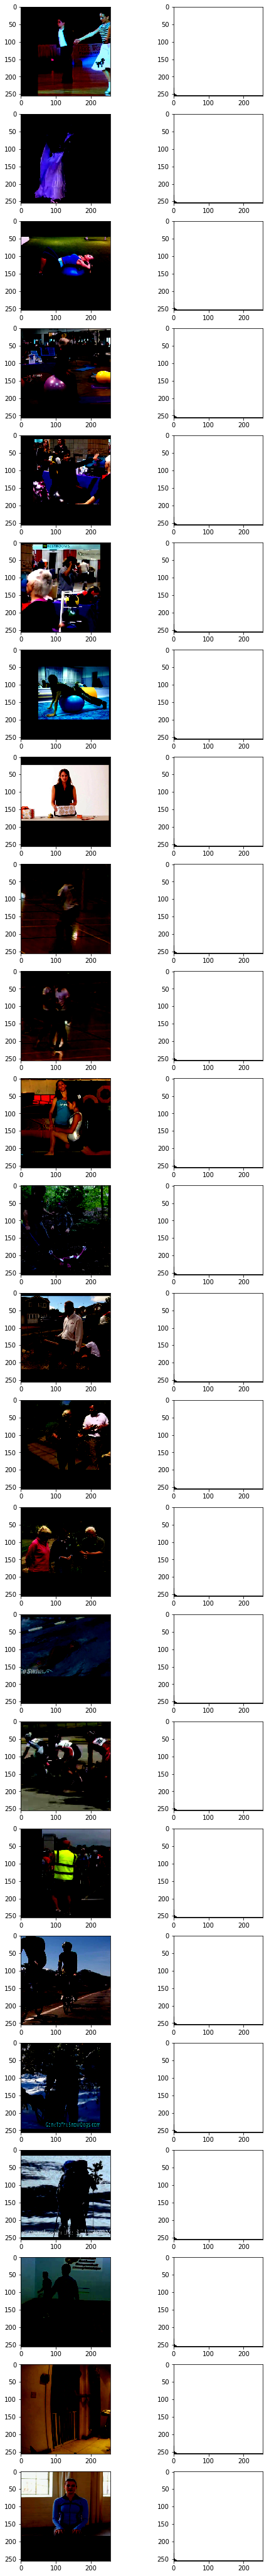

In [21]:
import matplotlib.pyplot as plt

n_cols = 2
n_rows = len(data['frame'])
fig = plt.figure(figsize=(8, 75))

print(len(data['frame']))
print(len(pred[0]))

i_img = 1
for i, data_img in enumerate(data['frame']):
    fig.add_subplot(n_rows, n_cols, i_img)
    plt.imshow(data_img)
    
    pred_img = pred[0][i]
    fig.add_subplot(n_rows, n_cols, i_img + 1)
    plt.imshow(pred_img)
    
    i_img += 2
    
plt.show()